# Overview

VLA 22A-020 observed NaCl and KCl transitions toward Sgr B2 in the Ku band.

PRIMOS detected NaCl 1-0 emission (in 5 hyperfine transitions) at 13.026 GHz at T$_A^*\sim0.05$ K.  The GBT beam at 13 GHz is 

In [1]:
import numpy as np
from astropy import units as u

In [2]:
from spectral_cube import SpectralCube

In [3]:
nacl10rest = 13.026012279345801*u.GHz

In [4]:
gbtbeam = (1.22 * nacl10rest.to(u.m, u.spectral()) / (100*u.m)).to(u.arcsec, u.dimensionless_angles())
gbtbeamarea = (2*np.pi*(gbtbeam/2.35)**2)
gbtbeam

<Quantity 57.91541645 arcsec>

This gives a flux density:

In [5]:
(0.05*u.K ).to(u.Jy, u.brightness_temperature(frequency=nacl10rest, beam_area=gbtbeamarea))

<Quantity 0.02338014 Jy>

The observations achieved a beam size about 0.4"x0.2" with robust=2:

In [6]:
cd ../imaging_Darray

/orange/adamginsburg/sgrb2/22A-020/imaging_Darray


In [7]:
vlabeam = SpectralCube.read('Kuband_Darray.sgrb2.spw13.robust0.5.liteclean.image').beams.common_beam()
vlabeam

/blue/adamginsburg/adamginsburg/repos/casa-formats-io/casa_formats_io/casa_dask.py:247: RuntimeWarning: divide by zero encountered in scalar remainder
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


Beam: BMAJ=28.285557936108724 arcsec BMIN=3.4233383154253905 arcsec BPA=-3.5351436413584256 deg

If the emission were concentrated into a single beam, then the peak brightness would be:

In [8]:
0.05*u.K * (gbtbeamarea/vlabeam.sr).decompose()

<Quantity 1.73909587 K>

The typical uncertainty achieved in our data is:

In [9]:
uncertainty = SpectralCube.read('Kuband_Darray.sgrb2.spw13.robust0.5.liteclean.image', use_dask=True).std()
uncertainty

/blue/adamginsburg/adamginsburg/repos/casa-formats-io/casa_formats_io/casa_dask.py:247: RuntimeWarning: divide by zero encountered in scalar remainder
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


<Quantity 0.210386 Jy / beam>

In [10]:
uncertainty.to(u.K, u.brightness_temperature(nacl10rest, beam_area=vlabeam))

<Quantity 15.64924028 K>

This is per channel with width:

In [11]:
SpectralCube.read('Kuband_Darray.sgrb2.spw13.robust0.5.liteclean.image').with_spectral_unit(u.km/u.s, rest_value=nacl10rest, velocity_convention='radio').spectral_axis.diff().mean()

/blue/adamginsburg/adamginsburg/repos/casa-formats-io/casa_formats_io/casa_dask.py:247: RuntimeWarning: divide by zero encountered in scalar remainder
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


<Quantity -0.35961443 km / s>

### listobs: 

https://data.rc.ufl.edu/secure/adamginsburg/SgrB2/22A-020/22A-020_sb41854545_1_1.59783.16907671296/pipeline-20220725T214145/html/t2-1.html?sidebar=sidebar_22A_020_sb41854545_1_1_59783_16907671296_ms&subpage=listobs.txt


In [67]:
pth = 'Kuband_Darray.sgrb2.spw13.robust0.5.liteclean.image'
naclcube_withcont = SpectralCube.read(pth).with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nacl10rest)
cont_est = naclcube_withcont.median(axis=0)

if False: # the continuum subtraction is handled in contsub.py
    if not os.path.exists(pth+".contsub.fits"):
        naclcube = SpectralCube.read(pth).with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nacl10rest)
        cont = naclcube.median(axis=0)
        contsub = naclcube - cont
        contsub.write(pth+".contsub.fits")
naclcube = SpectralCube.read(pth+".contsub.fits").with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nacl10rest)
naclcube

VaryingResolutionSpectralCube with shape=(921, 600, 600) and unit=Jy / beam:
 n_x:    600  type_x: RA---SIN  unit_x: deg    range:   266.786115 deg:  266.880709 deg
 n_y:    600  type_y: DEC--SIN  unit_y: deg    range:   -28.419436 deg:  -28.336242 deg
 n_s:    921  type_s: VRAD      unit_s: km / s  range:      -87.799 km / s:     243.046 km / s

In [68]:
%matplotlib inline
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['image.interpolation'] = 'none'
from spectral_cube import SpectralCube
from astropy import units as u
from astropy.visualization import quantity_support, simple_norm
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x14c8a3463880>

In [69]:
cont_est.value[np.isfinite(cont_est.value)]

array([ 0.        , -0.20697454, -0.19944623, ..., -0.21509133,
       -0.20864029,  0.        ], dtype=float32)

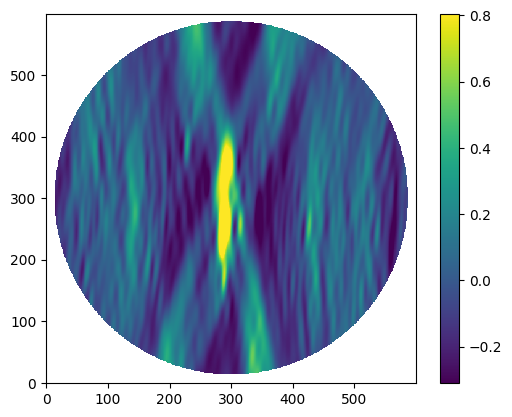

In [70]:
pl.imshow(cont_est.value, norm=simple_norm(cont_est.value, max_percent=99, min_percent=1))
pl.colorbar()

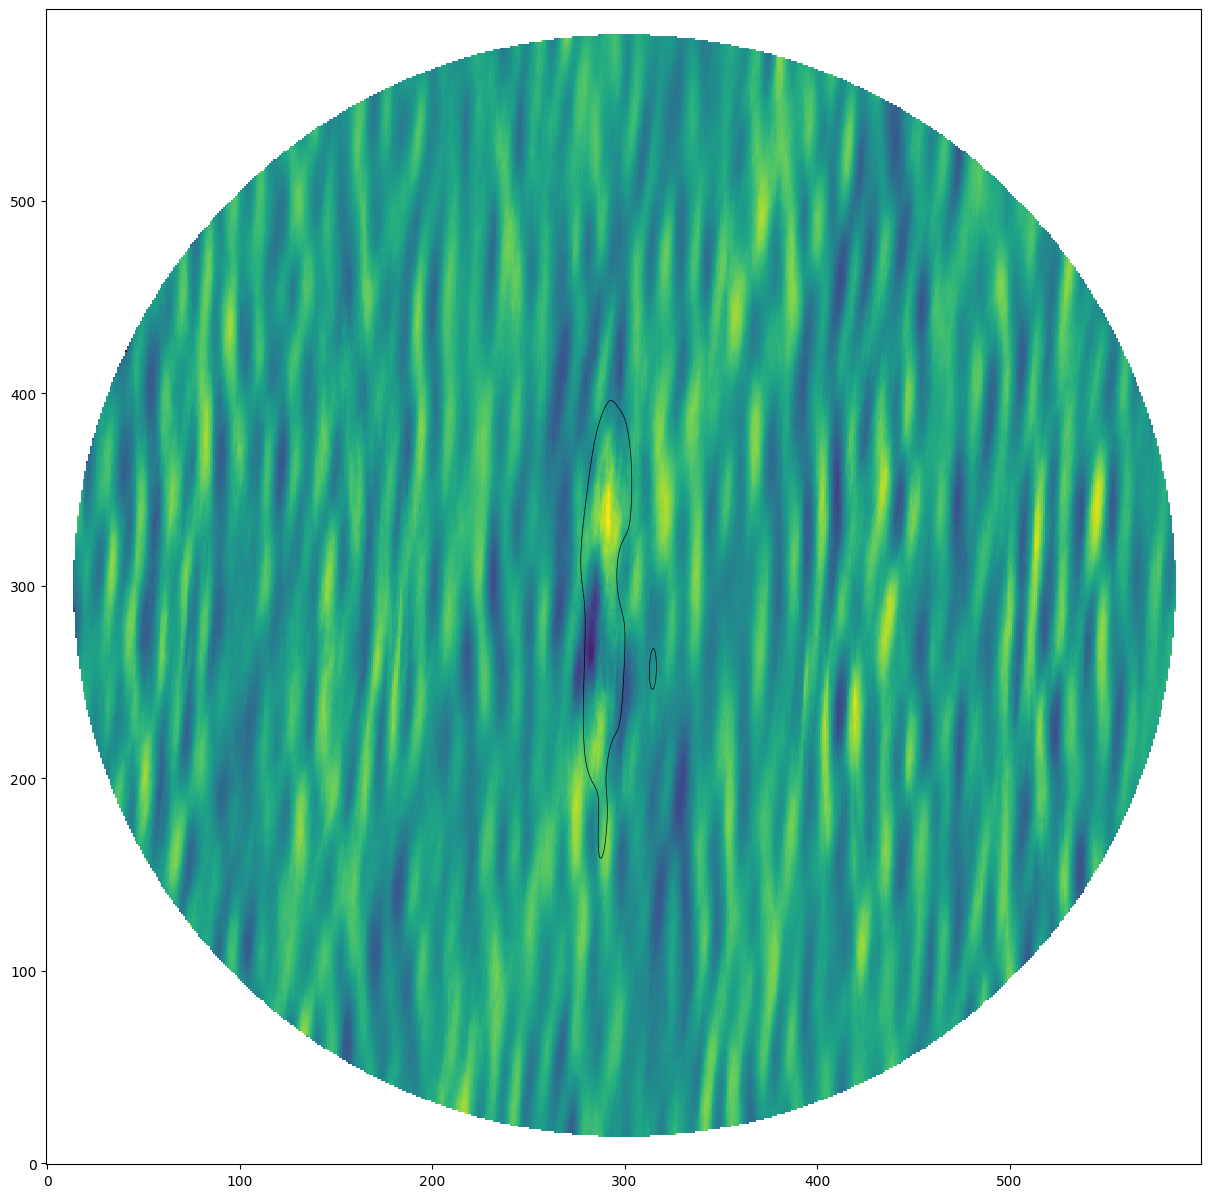

In [81]:
pl.figure(figsize=(15, 15))
m0 = naclcube.spectral_slab(40*u.km/u.s, 76*u.km/u.s).moment0(axis=0)
pl.imshow(m0.value)
pl.contour(cont_est.value, cmap='inferno', linewidths=0.5, levels=[0.6])

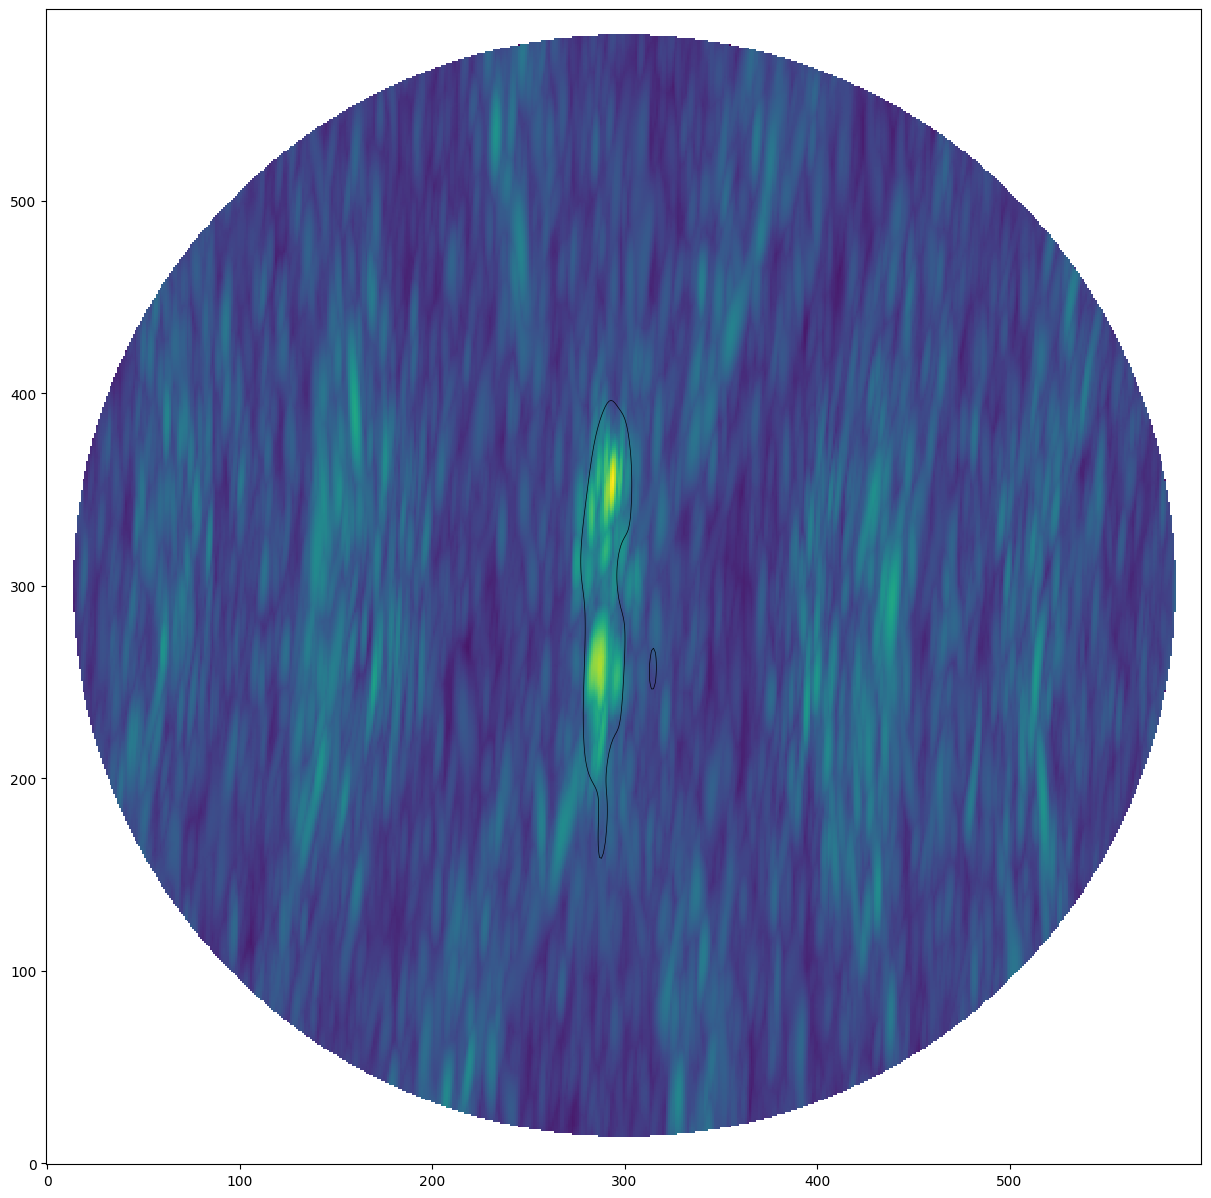

In [82]:
pl.figure(figsize=(15, 15))
mx = naclcube.spectral_slab(40*u.km/u.s, 76*u.km/u.s).max(axis=0)
pl.imshow(mx.value)
pl.contour(cont_est.value, cmap='inferno', linewidths=0.5, levels=[0.6])

# Spectra from target regions

In [16]:
import regions

In [17]:
hiiregions = regions.Regions.read("../regions_2018paper/SgrB2_1.3cm_hiiRegions_masked_Done.reg")
named_regions = {r.meta['text']: r for r in hiiregions if 'text' in r.meta}

In [18]:
targets = [('K1', 'K2', 'K3'), 'K4', 'Z10.24', 'I', 'E', 'B', 'G', ('F2', 'F1', 'F10.303', 'F3', 'F4')]

In [19]:
def getreg(tgt):
    if isinstance(tgt, tuple):
        reg = regions.Regions([named_regions[x] for x in tgt])
    else:
        reg = regions.Regions([named_regions[tgt]])                              
    return reg

In [20]:
ls -d *spw16*fits

KbandDarray.sgrb2.spw16.robust0.5.liteclean.image.contsub.25.30.fits
KbandDarray.sgrb2.spw16.robust0.5.liteclean.image.contsub.fits
Kuband_Darray.sgrb2.spw16.robust0.5.liteclean.image.contsub.14.49.fits
Kuband_Darray.sgrb2.spw16.robust0.5.liteclean.image.contsub.fits


In [21]:
ls -d all*spw31*

ls: cannot access 'all*spw31*': No such file or directory


In [22]:
fns = ['Kuband_Darray.sgrb2.spw13.robust0.5.liteclean.image']

In [23]:
cubes = [SpectralCube.read(fn, use_dask=True) for fn in fns]

/blue/adamginsburg/adamginsburg/repos/casa-formats-io/casa_formats_io/casa_dask.py:247: RuntimeWarning: divide by zero encountered in scalar remainder
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


In [24]:
h2co22freq = 14.488*u.GHz

In [25]:
import warnings
warnings.filterwarnings('ignore')

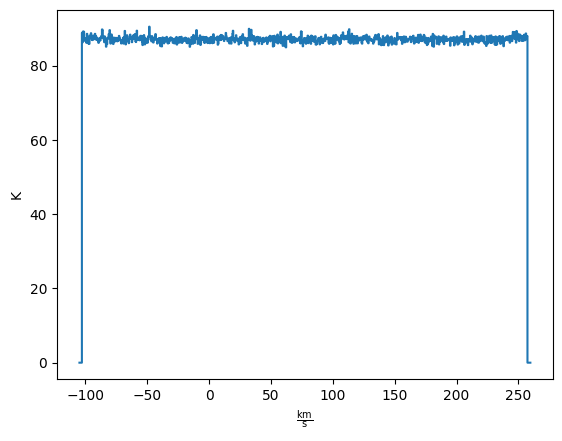

In [26]:
for tgt in targets:
    reg = getreg(tgt)
cube=cubes[0]
meanspec = cube.subcube_from_regions(reg).with_spectral_unit(u.km/u.s, rest_value=nacl10rest, velocity_convention='radio').to(u.K).mean(axis=(1,2))
meanspec[5:-5].with_spectral_unit(u.km/u.s).quicklook()

# Targeted line list

In [42]:
lines_ = """NaClv=4                        12.64256          1-0
Na37Clv=1                      12.6537338          1-0
  NaClv=3                      12.7375094          1-0
  NaClv=2                       12.833076          1-0
  NaClv=1                      12.9292599          1-0
  NaClv=0                       13.026061          1-0
  NaClv=4                      25.2848979          2-1
Na37Clv=1                      25.3072535          2-1
  NaClv=3                      25.4747961          2-1
  NaClv=2                      25.6659289          2-1
  NaClv=1                      25.8582961          2-1
  NaClv=0                      26.0518979          2-1
KClv=2                     7.5947557581797485     1-0
KClv=1                     7.641908716029236      1-0
KClv=0                     7.688854873394778      1-0
41KClv=2                       14.842043          2-1
41KClv=1                      14.9327249          2-1
41KClv=1                       14.932747          2-1
41KClv=0                      15.0237965          2-1
41KClv=0                        15.02382          2-1
  KClv=2                       15.189845          2-1
  KClv=1                      15.2837547          2-1
  KClv=1                       15.283773          2-1
  KClv=0                       15.378067          2-1
  KClv=0                      15.3780746          2-1
  KClv=0                       15.378087          2-1 """
freqs = [float(x.split()[1]) for x in lines_.split("\n")]*u.GHz * (1 - 65/3e5)
names = np.array([x.split()[0] + " " + x.split()[-1] for x in lines_.split("\n")])
names_dict = {n: f for n, f in zip(names, freqs)}

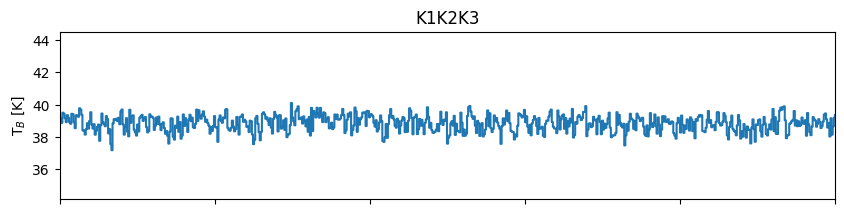

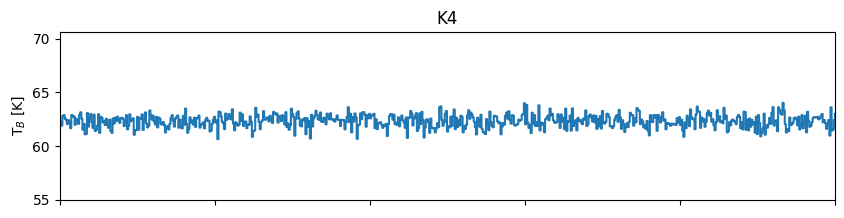

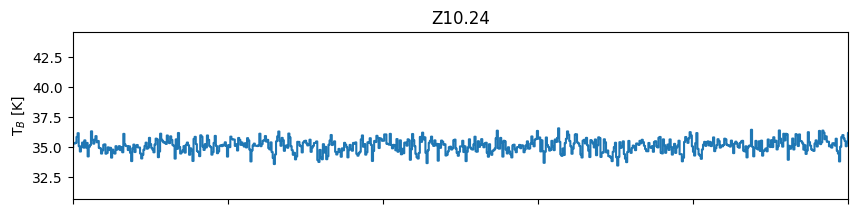

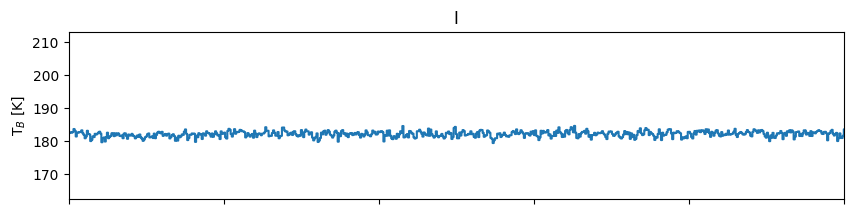

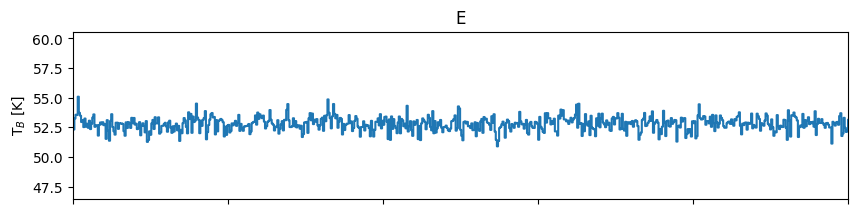

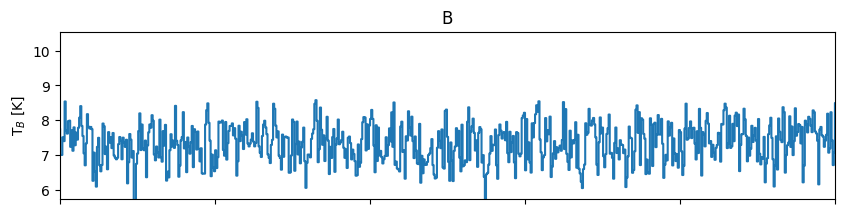

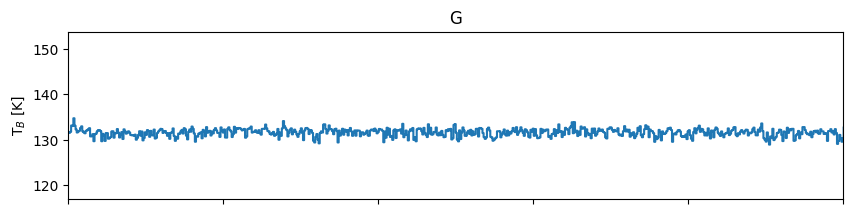

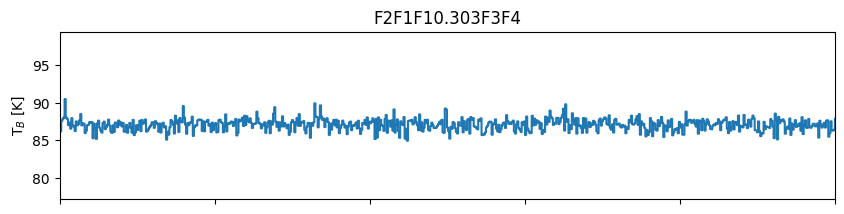

In [43]:
for tgt in targets:
    reg = getreg(tgt)
    name = "".join(tgt)
    fig = pl.figure(figsize=(10,10))
    for ii, cube in enumerate(cubes):
        ax = pl.subplot(4,1,ii+1)
        meanspec = cube.subcube_from_regions(reg).with_spectral_unit(u.km/u.s, rest_value=nacl10rest if ii<3 else h2co22freq, velocity_convention='radio').to(u.K).mean(axis=(1,2))
        if ii < 3:
            meanspec = meanspec[3:-3].with_spectral_unit(u.km/u.s) # chop out bad edge pixels
        ax.plot(meanspec.spectral_axis, meanspec.value, drawstyle='steps-mid')
        ax.set_xlim(-50, 200)
        ax.set_ylim(np.percentile(meanspec.value, 5)*0.9, np.percentile(meanspec.value, 99.99)*1.1)
        if ii == 3:
            ax.set_xlabel("V$_{LSR}$ [km/s]")
        else:
            ax.set_xticklabels('')
            ax.set_xlabel("")
        ax.set_ylabel("T$_B$ [K]")
        if ii == 0:
            ax.set_title(name)
    fig.savefig(f"../figures/{name}_KuBand_Darray_spectra.png")

In [44]:
pwd

'/orange/adamginsburg/sgrb2/22A-020/imaging_Darray'

In [45]:
from astropy.table import Table
from astropy import constants

In [46]:
from astropy.table import Table
primos = Table.read('../PRIMOS_spectrum.txt', format='ascii.no_header')
pfrq = (primos['col1'] * u.MHz * (1-64*u.km/u.s/constants.c)).to(u.GHz)
pamp = primos['col2'] * u.K

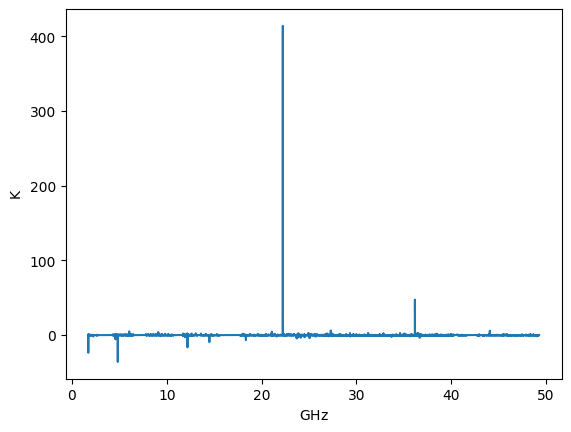

In [47]:
pl.plot(pfrq,pamp)

In [48]:
from astropy.coordinates import SkyCoord

In [49]:
primos_center = SkyCoord('17h47m19.8', '-28:22:17', unit=(u.h, u.deg), frame='fk5')

In [50]:
import glob
import regions
from astropy import wcs
from astropy.io import fits

In [51]:
mkdir -p primos_spectra/pngs

In [52]:
import warnings
warnings.filterwarnings('ignore')

# PRIMOS comparison

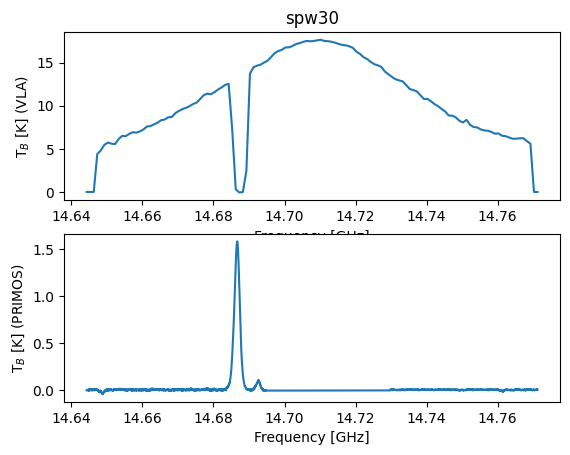

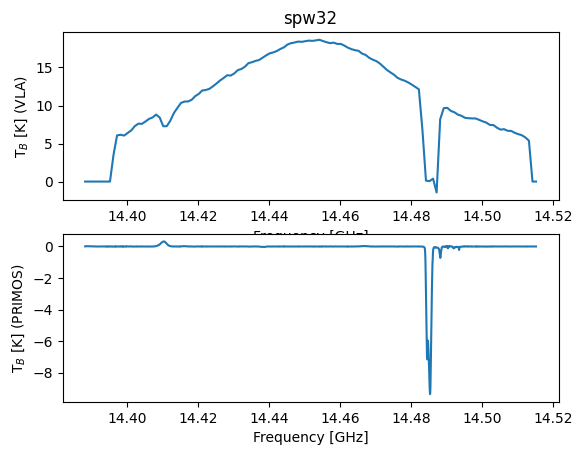

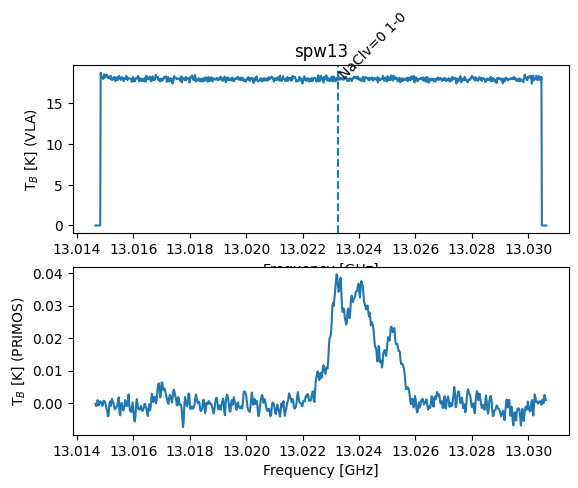

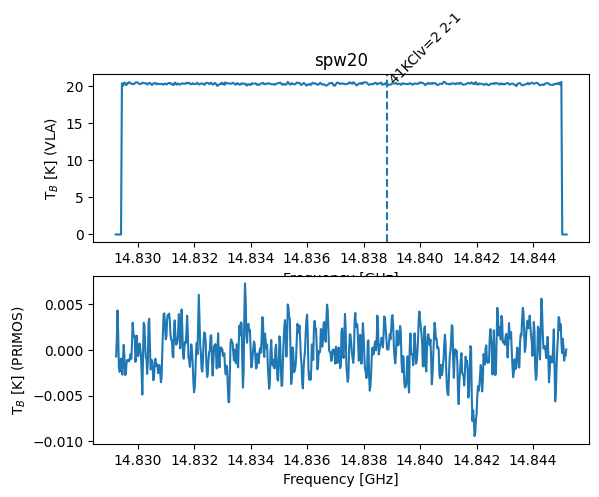

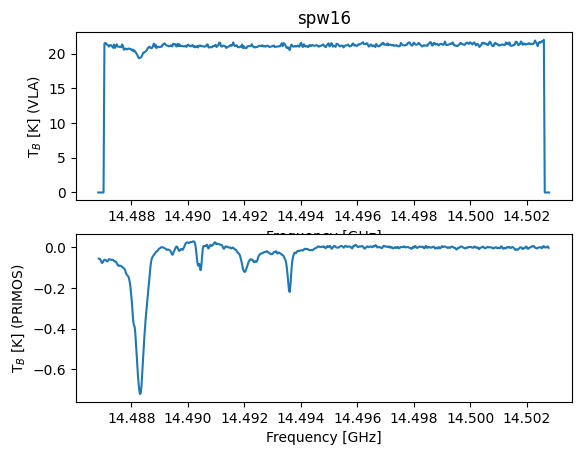

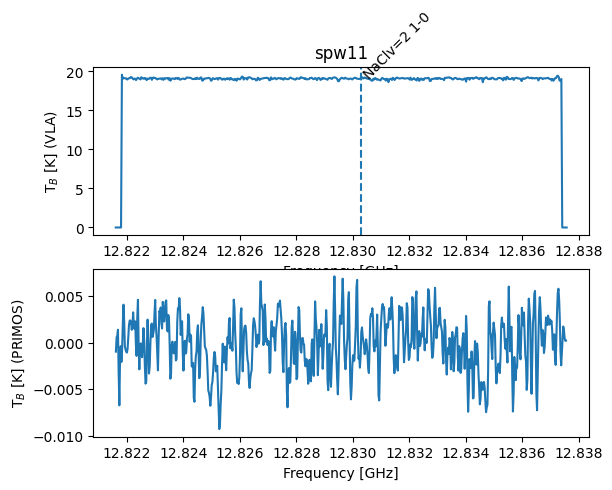

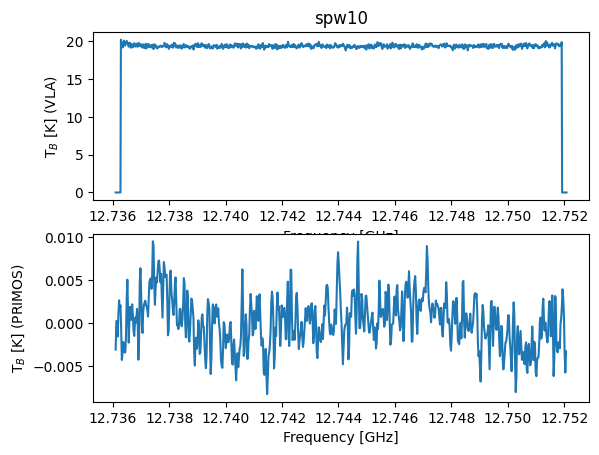

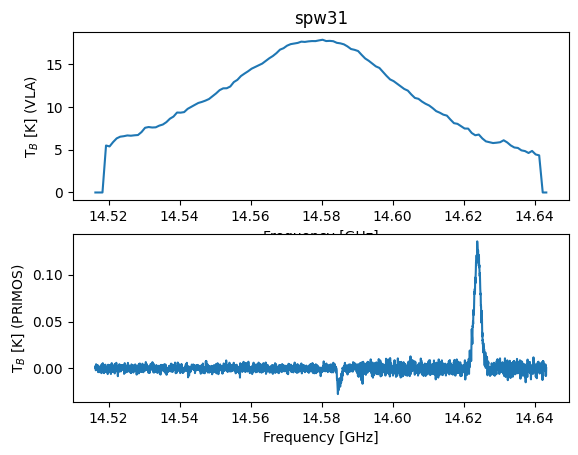

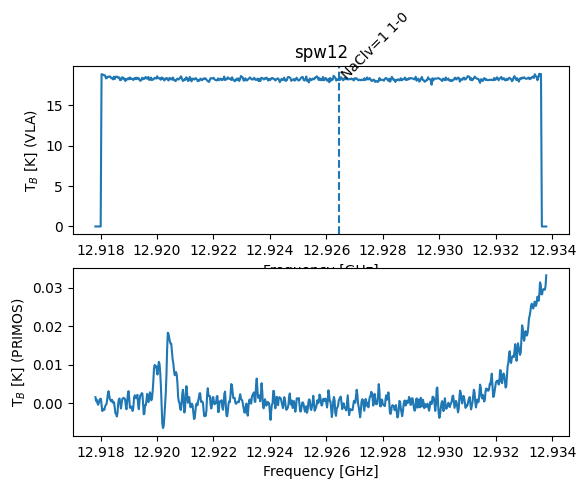

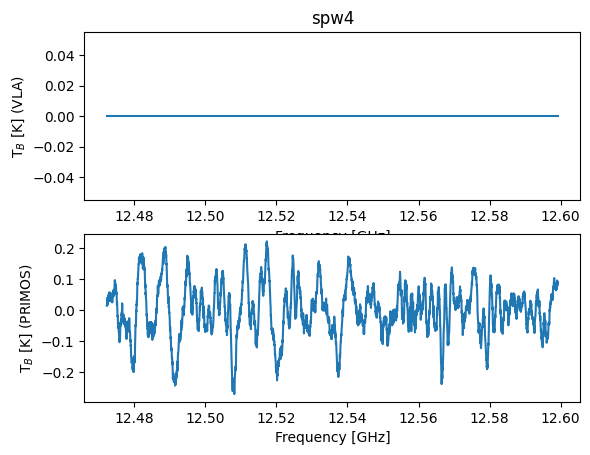

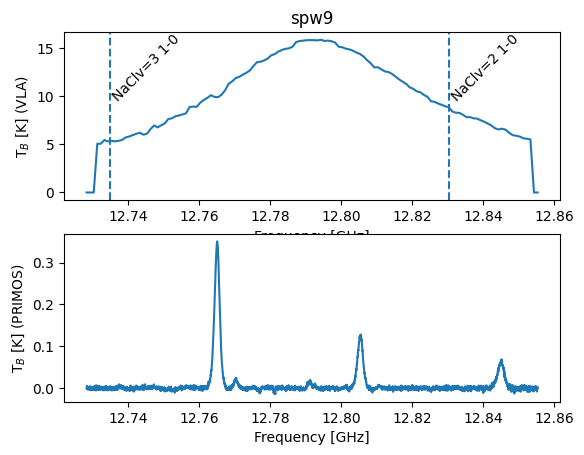

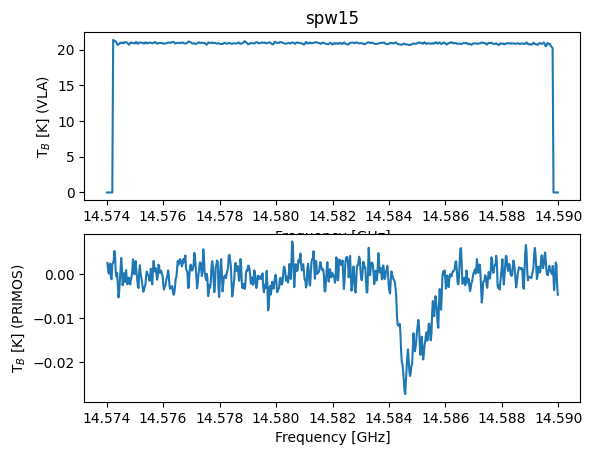

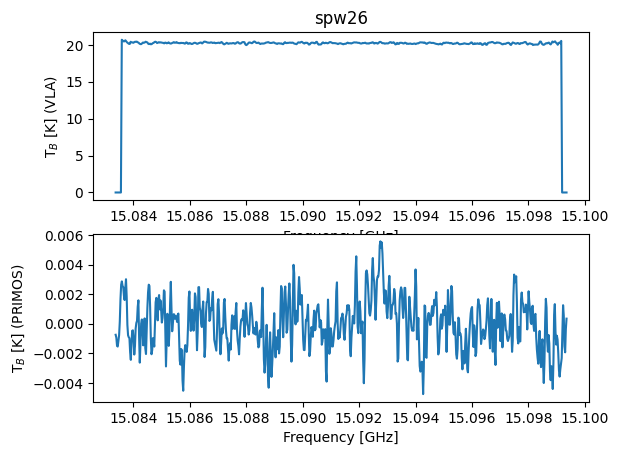

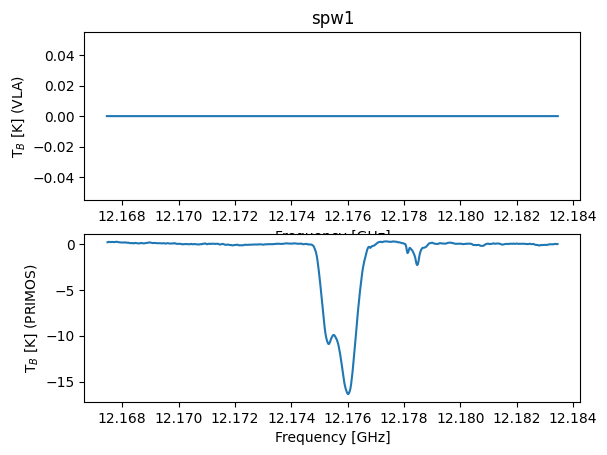

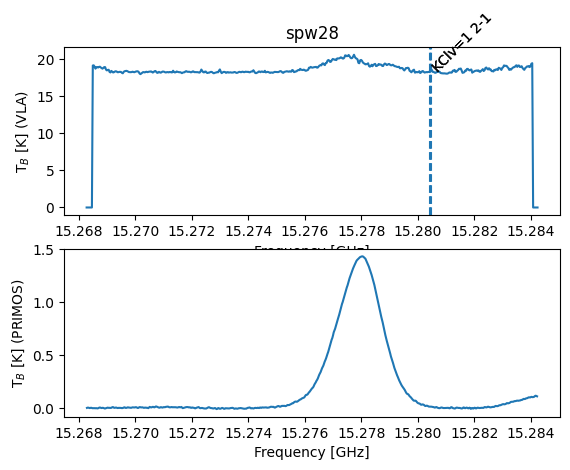

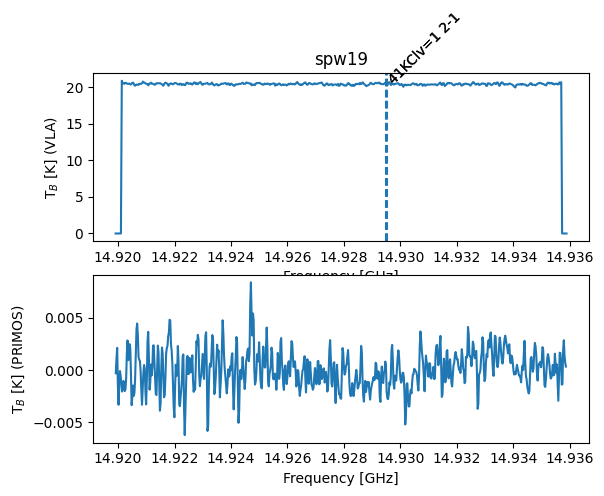

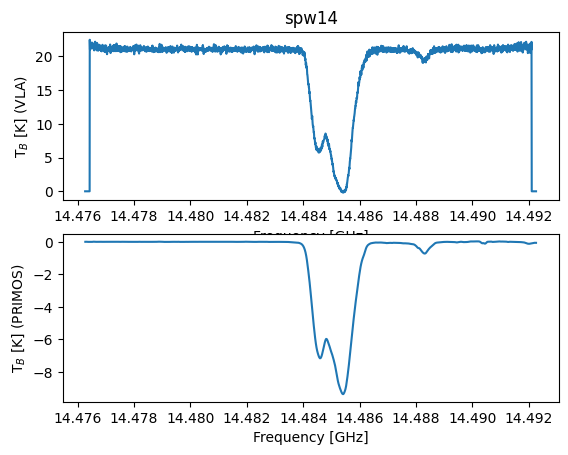

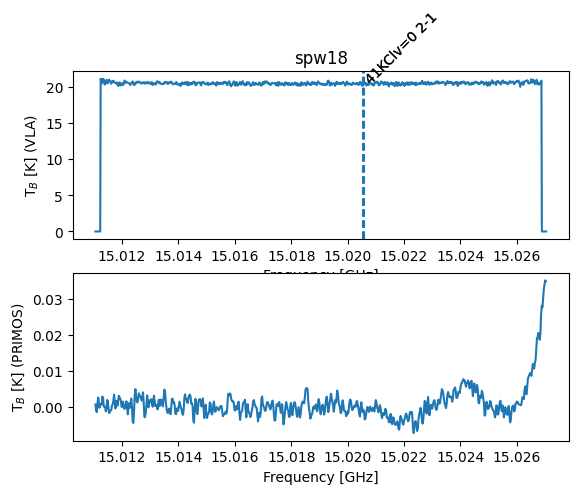

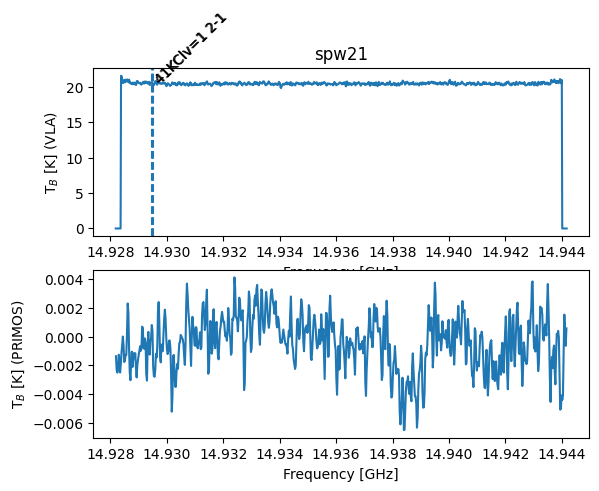

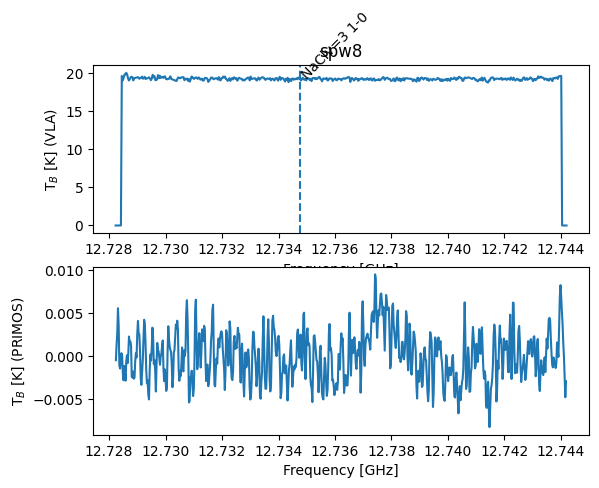

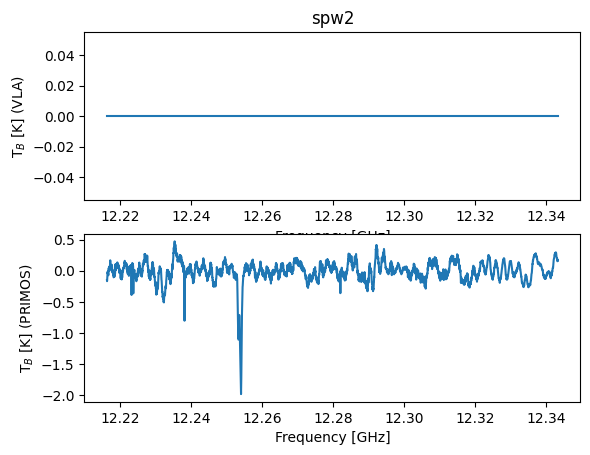

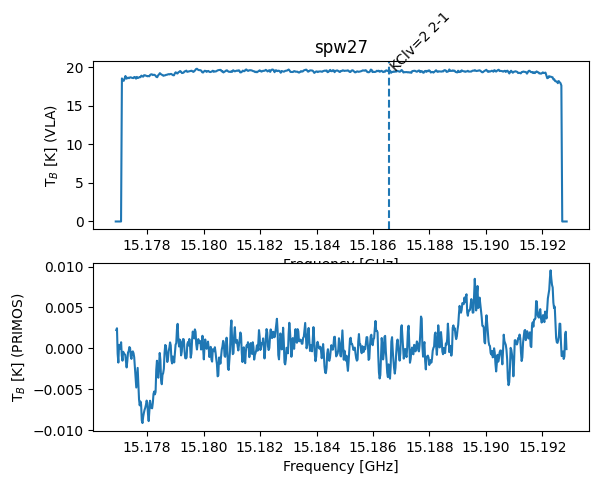

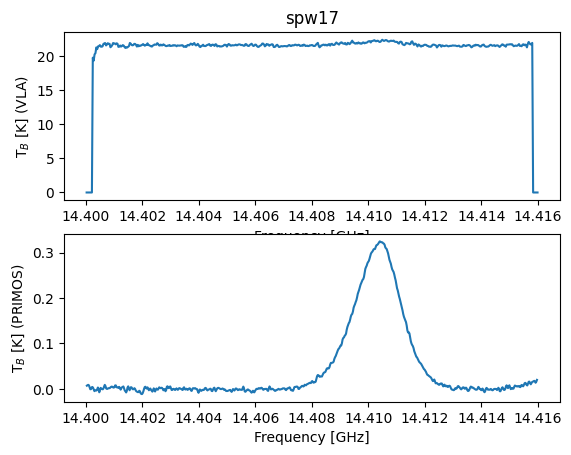

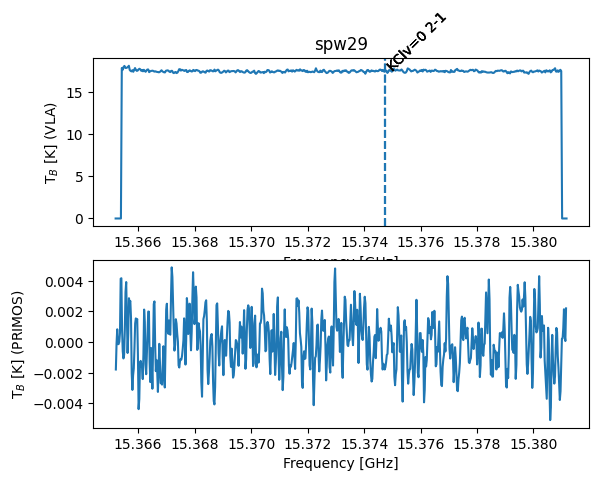

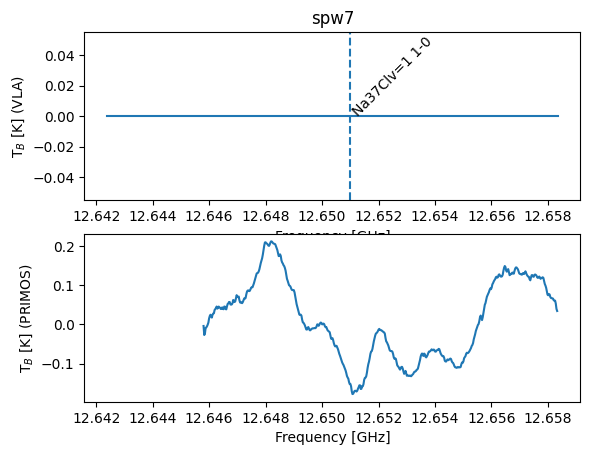

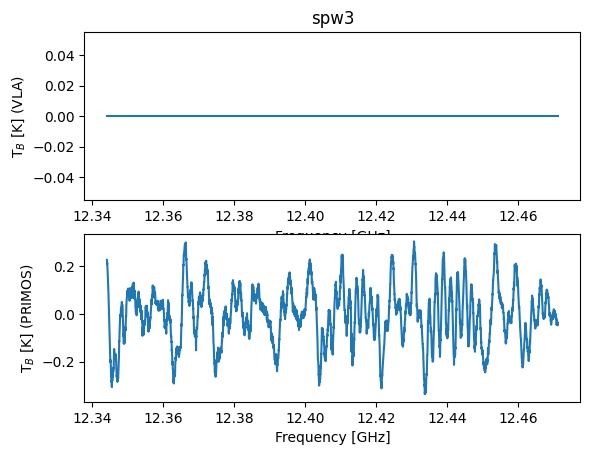

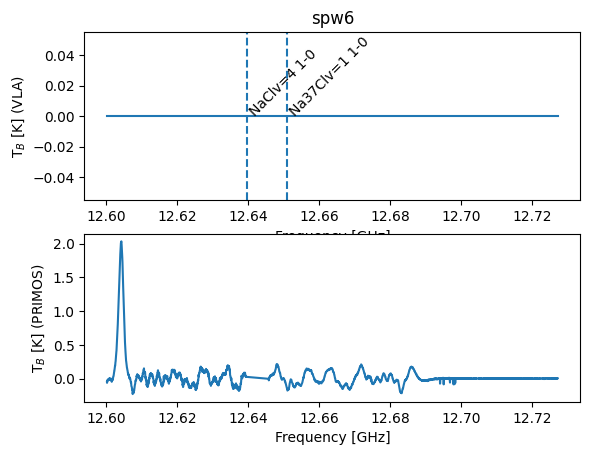

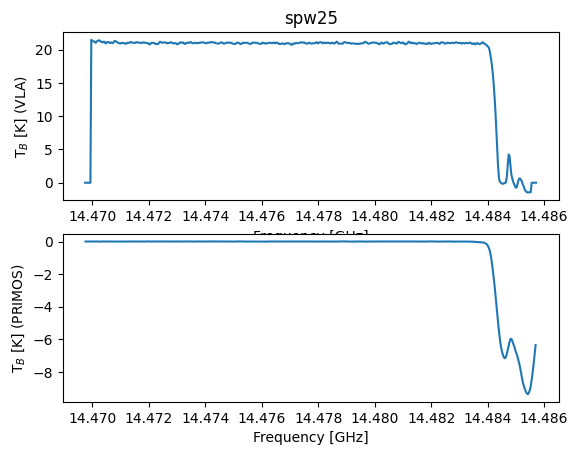

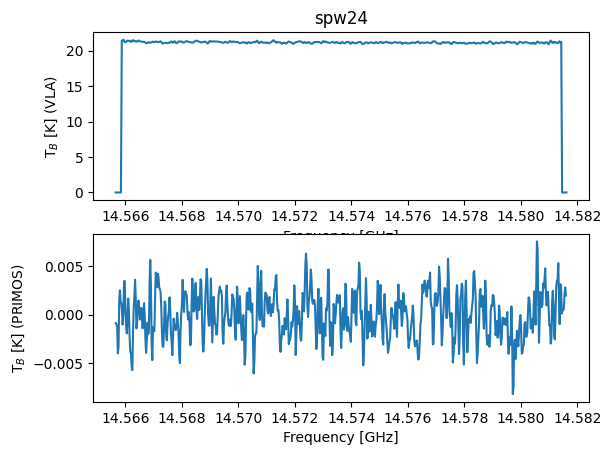

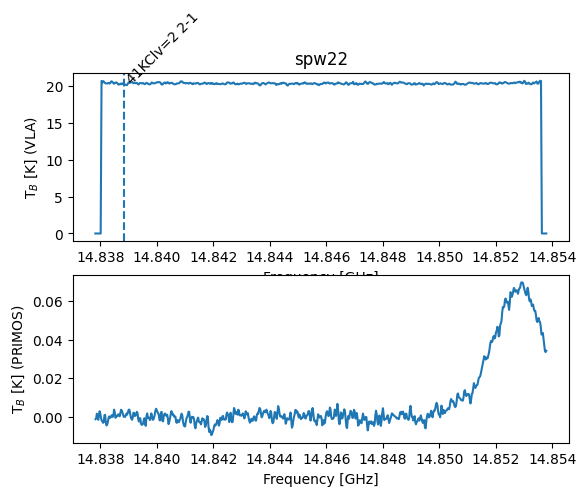

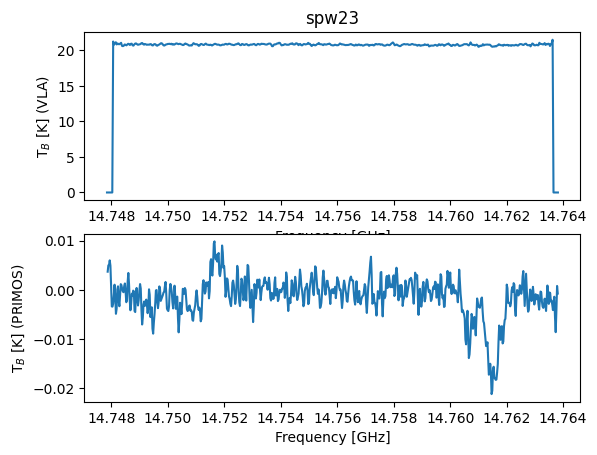

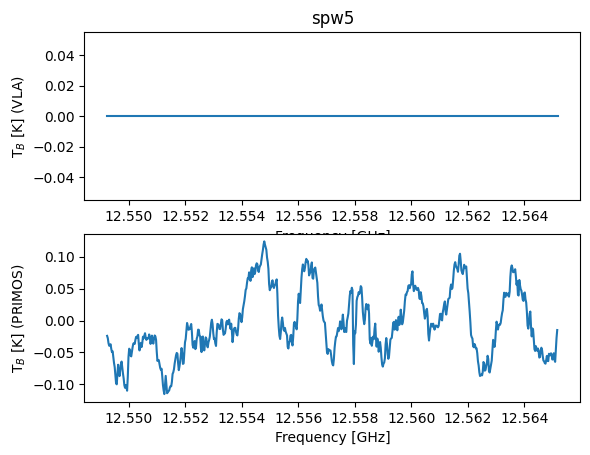

In [53]:
for fn in glob.glob("Kuband*.image"):
    if 'continuum' in fn:
        continue
    specfn = f'primos_spectra/{fn}.meanspec.fits'
    if not os.path.exists(specfn):
        cube = SpectralCube.read(fn, use_dask=True).with_spectral_unit(u.GHz)
        # estimate of GBT beam
        primos_fwhm = (cube.spectral_axis.mean().to(u.m, u.spectral()) / (100*u.m)).to(u.arcsec, u.dimensionless_angles())
        aperture = regions.CircleSkyRegion(center=primos_center, radius=primos_fwhm/2)
        try:
            subcube = cube.subcube_from_regions([aperture])
        except ValueError as ex:
            continue
        meanspec = subcube.mean(axis=(1,2)).to(u.K)
        hdu = meanspec.hdu
        hdu.writeto(specfn)
        xax = meanspec.spectral_axis
        yax = meanspec.value
    else:
        hdu = fits.open(specfn)[0]
        yax = hdu.data
        xax = wcs.WCS(hdu.header).pixel_to_world(np.arange(len(yax))).to(u.GHz)
    
    fig = pl.figure()
    ax = fig.add_subplot(2,1,1)
    ax.plot(xax, yax)
    ax.set_xlabel("Frequency [GHz]")
    ax.set_ylabel("T$_B$ [K] (VLA)")
    
    incl = (freqs > xax.min()) & (freqs < xax.max())
    if any(incl):
        for name, frq in zip(names[incl], freqs[incl]):
            ax.axvline(frq, linestyle='--',)
            ax.text(frq, np.nanmedian(yax), name, rotation=45)
    
    spw = [x for x in fn.split(".") if 'spw' in x][0]
    ax.set_title(spw)
    
    sel = (pfrq > xax.min()) & (pfrq < xax.max())
    ax2 = fig.add_subplot(2,1,2)
    ax2.plot(pfrq[sel], pamp[sel])
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xlabel("Frequency [GHz]")
    ax2.set_ylabel("T$_B$ [K] (PRIMOS)")
    
    fig.savefig(f'primos_spectra/pngs/{fn}.meanspec.png', bbox_inches='tight')

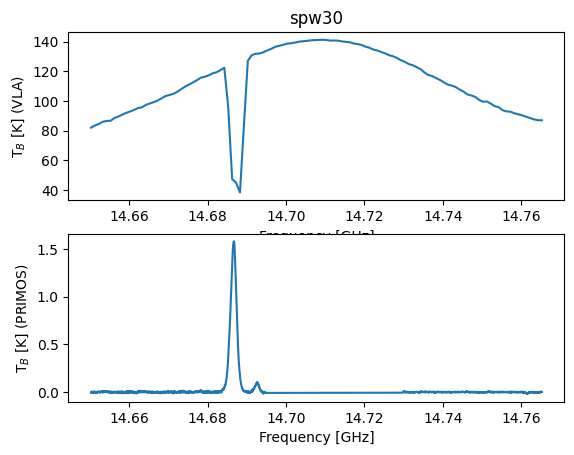

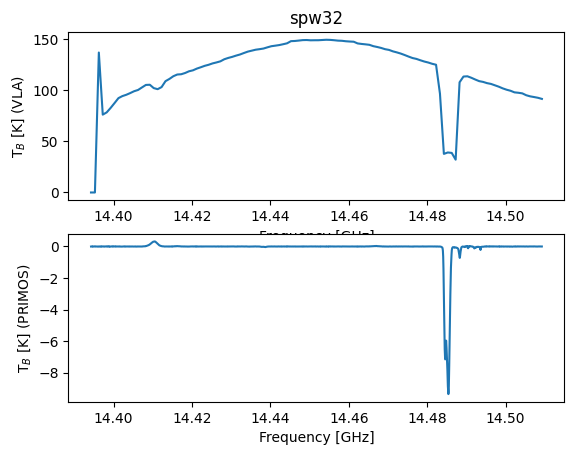

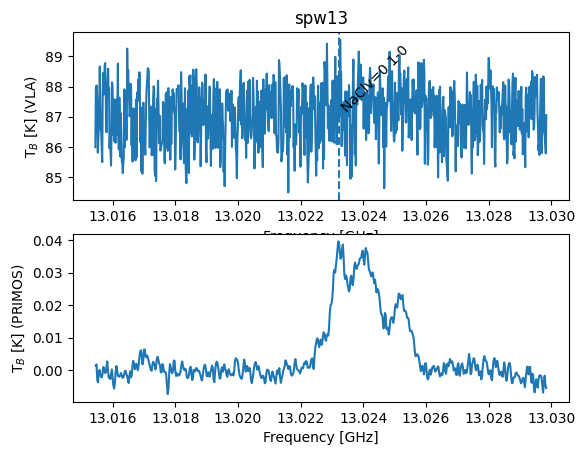

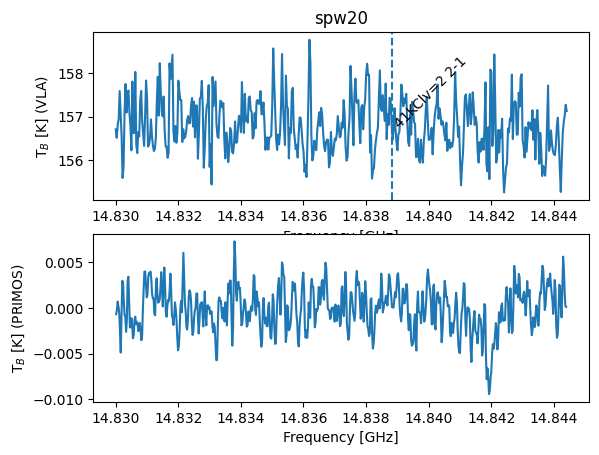

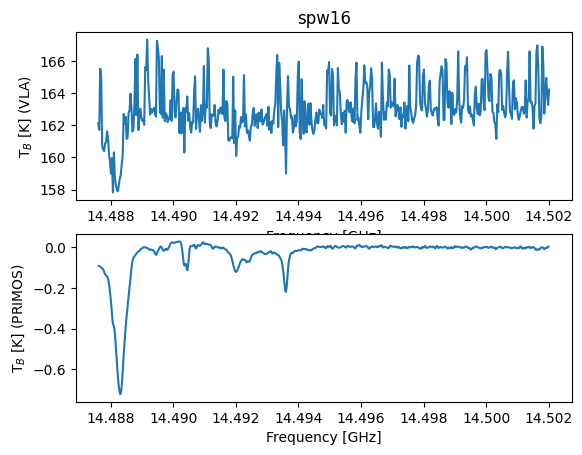

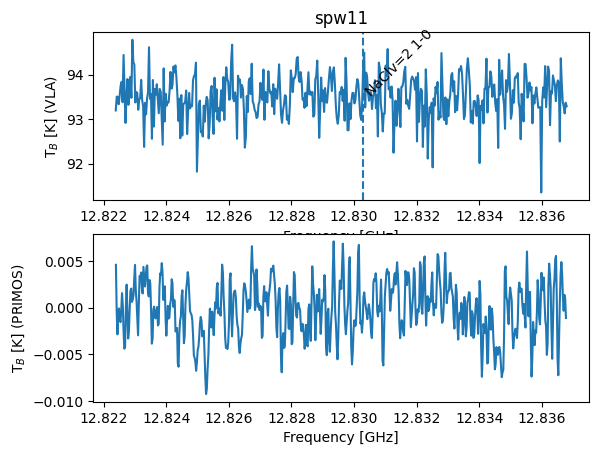

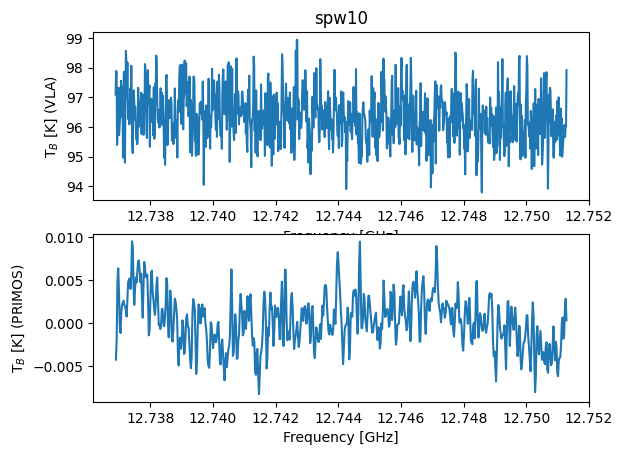

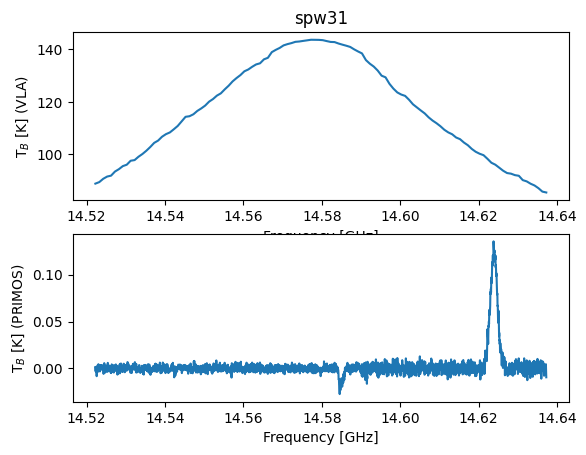

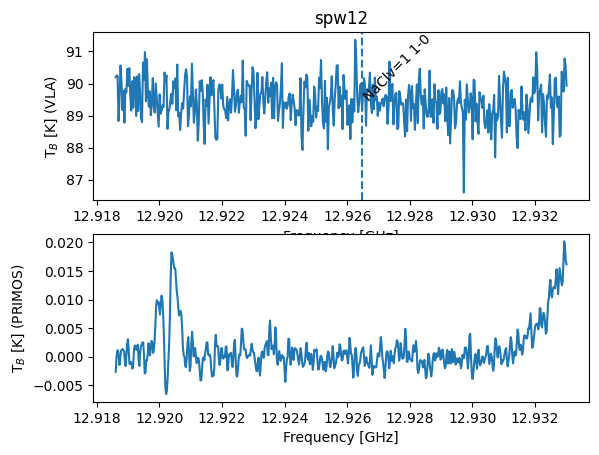

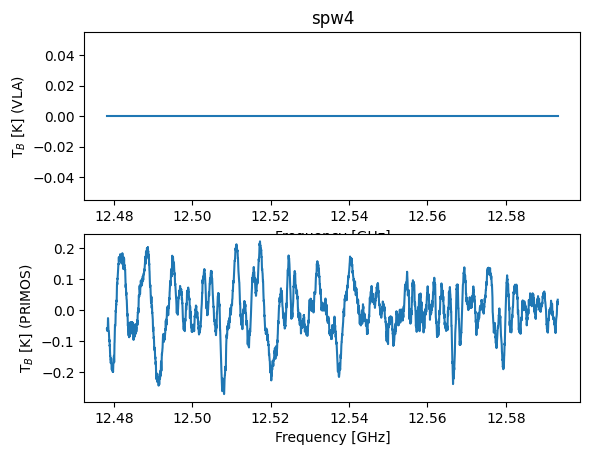

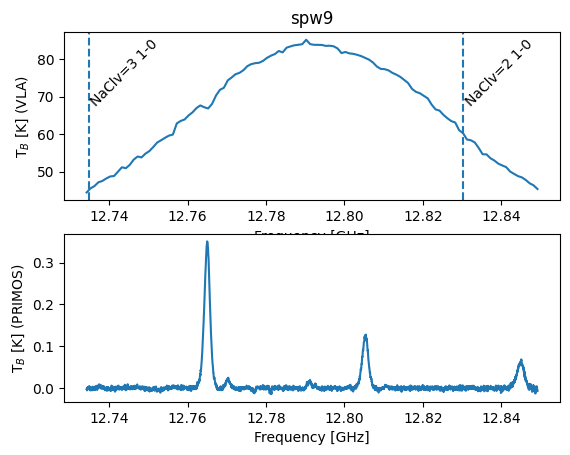

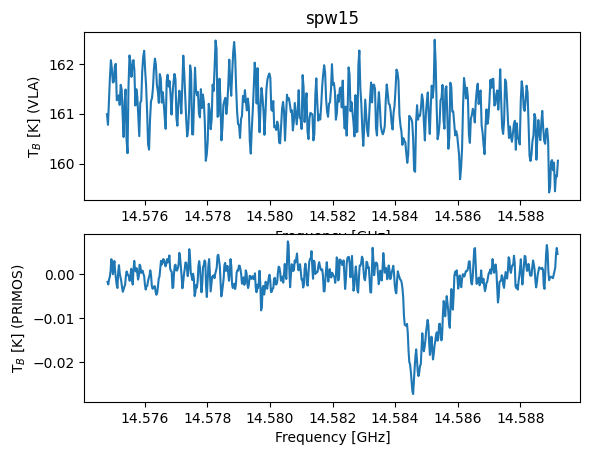

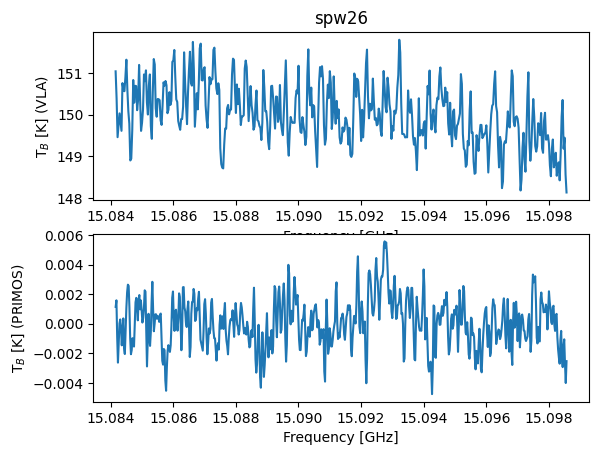

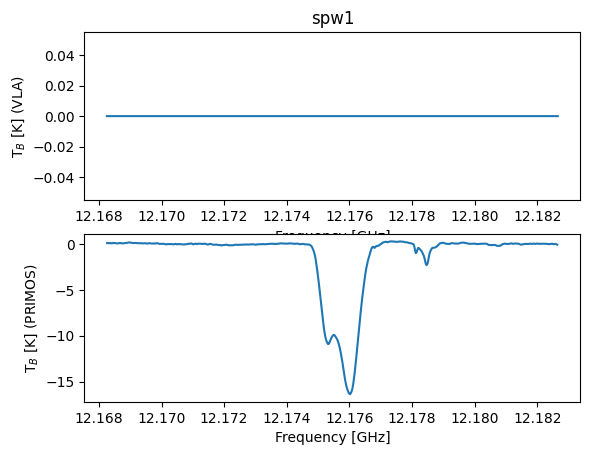

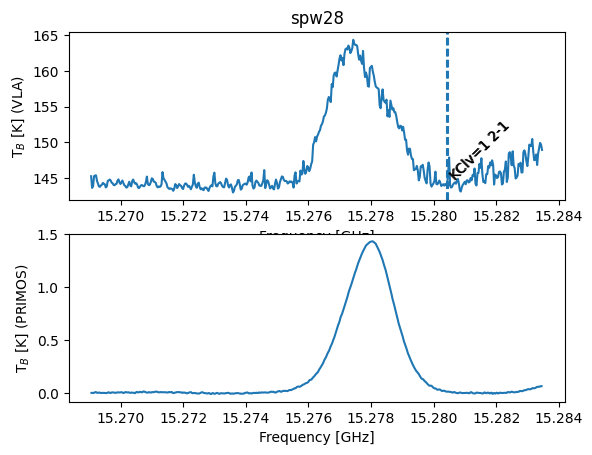

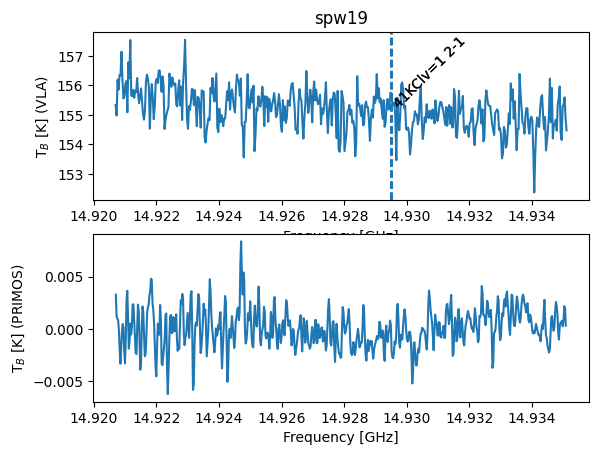

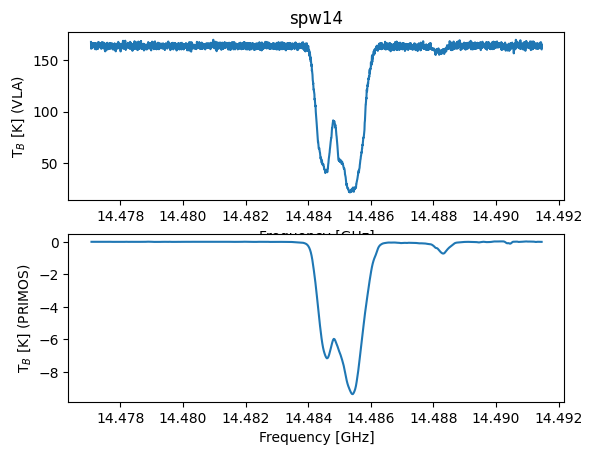

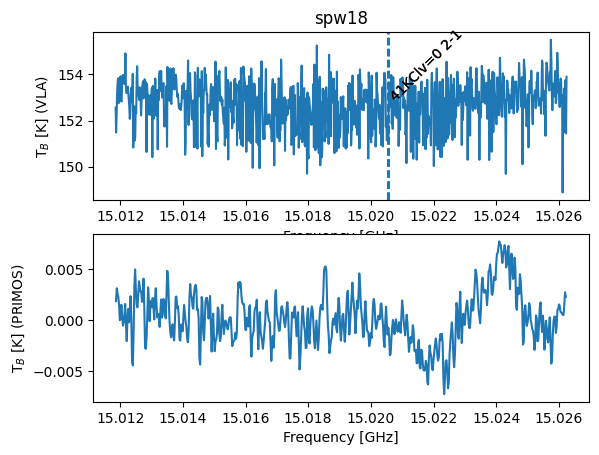

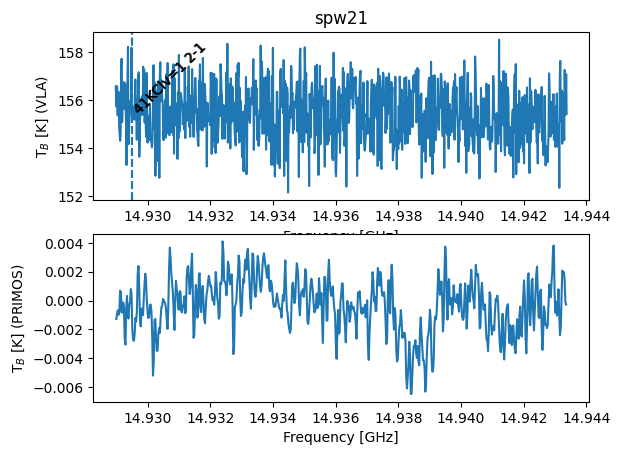

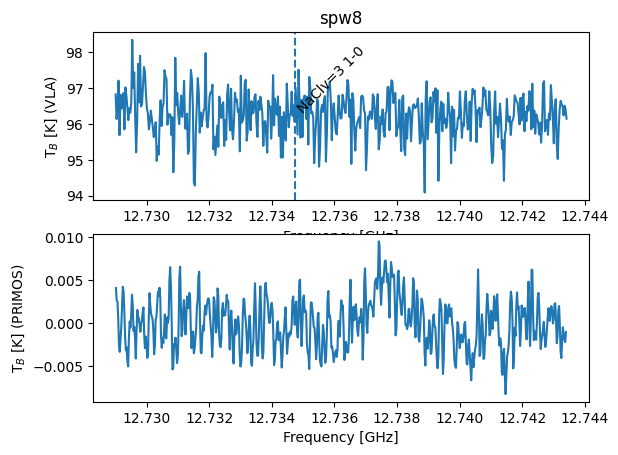

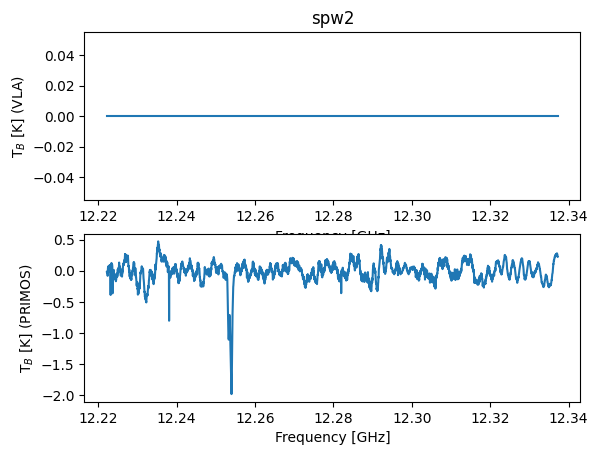

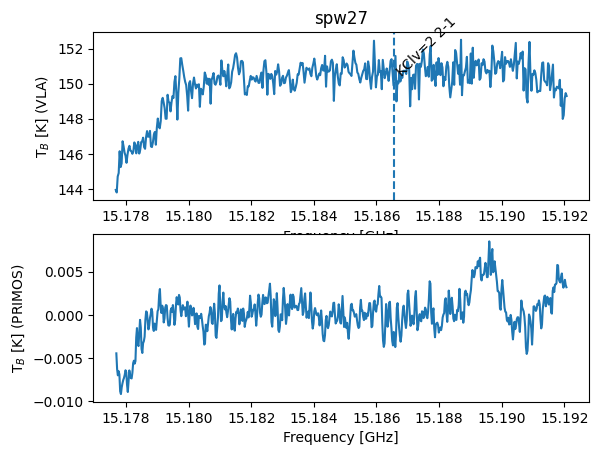

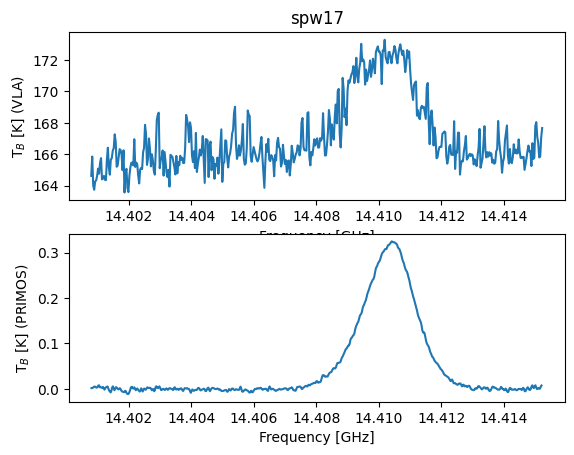

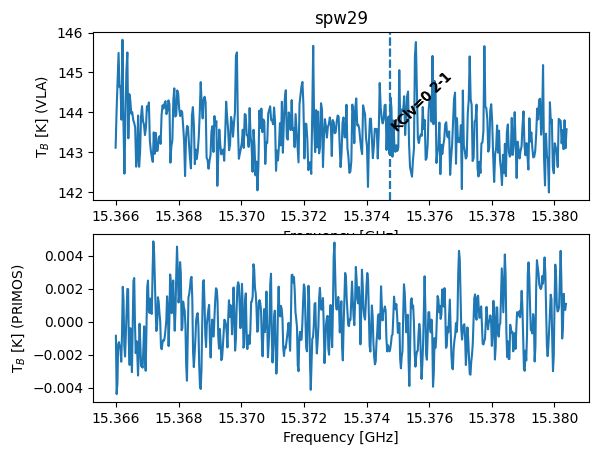

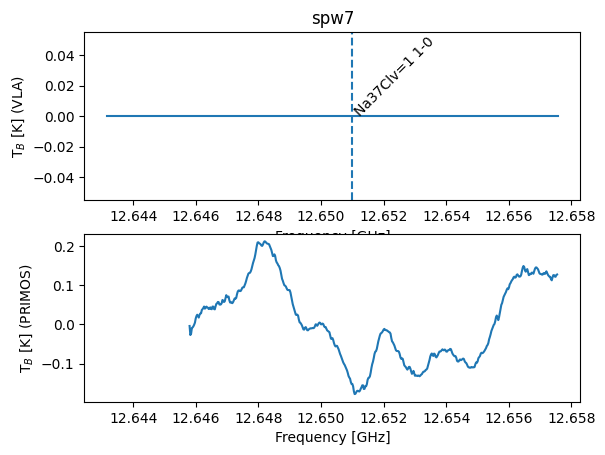

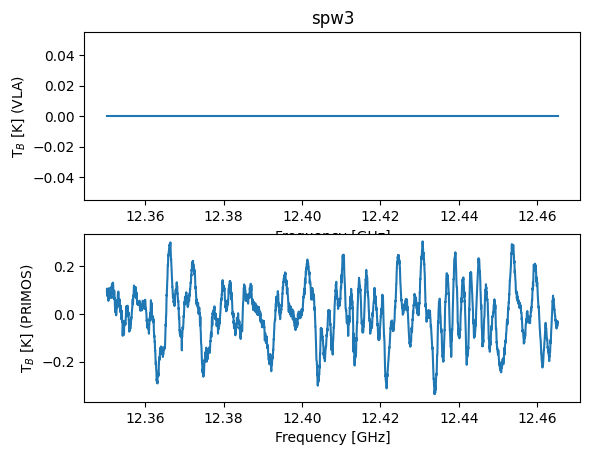

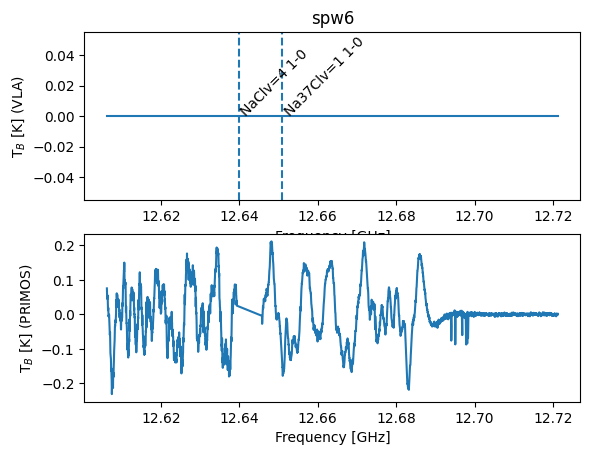

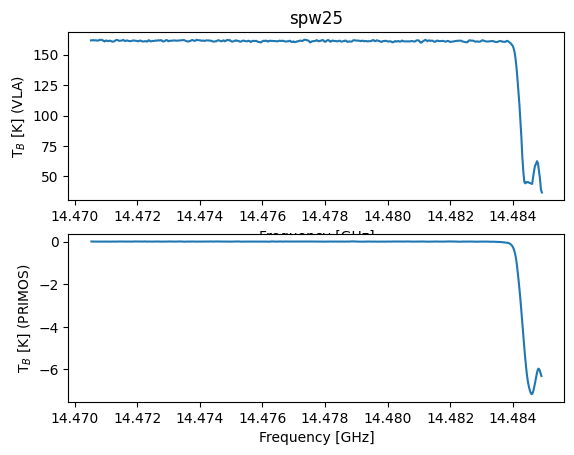

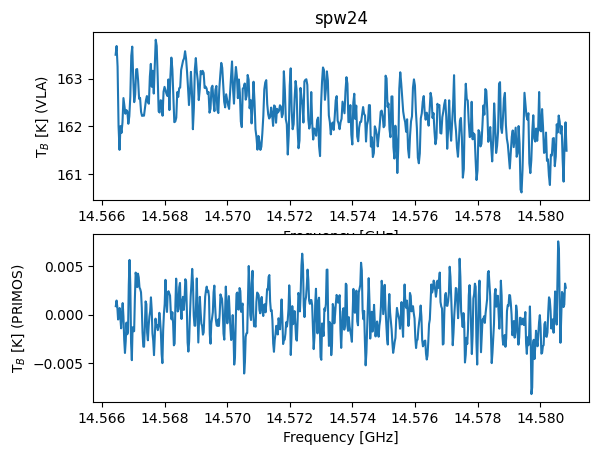

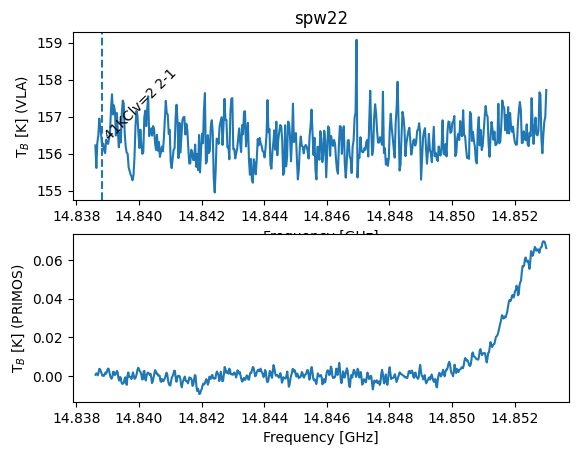

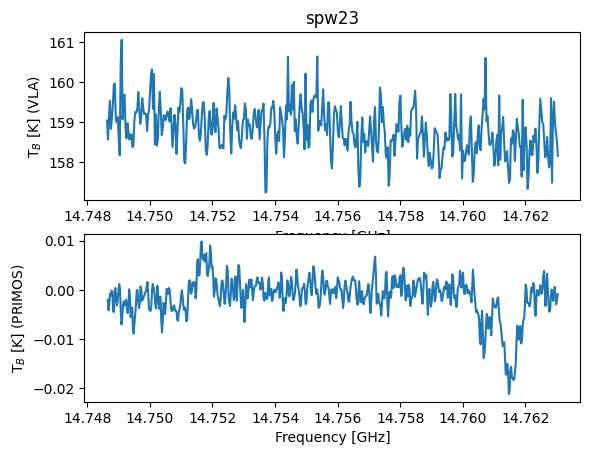

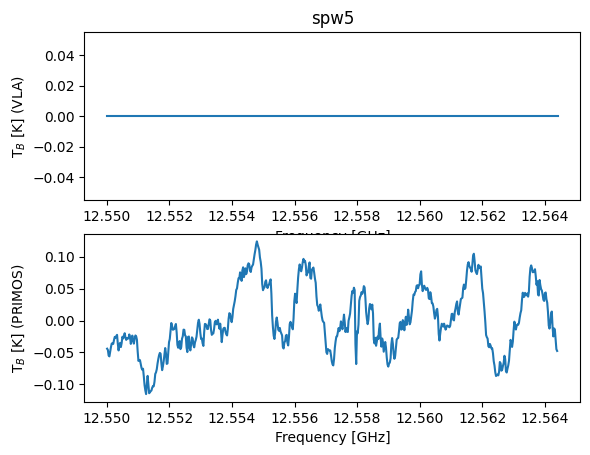

In [79]:
clip = 5

for fn in glob.glob("Kuband*.image"):
    if 'continuum' in fn:
        continue
    specfn = f'primos_spectra/{fn}.maxspec.fits'
    if not os.path.exists(specfn):
        cube = SpectralCube.read(fn, use_dask=True).with_spectral_unit(u.GHz)
        # estimate of GBT beam
        primos_fwhm = (cube.spectral_axis.mean().to(u.m, u.spectral()) / (100*u.m)).to(u.arcsec, u.dimensionless_angles())
        aperture = regions.CircleSkyRegion(center=primos_center, radius=primos_fwhm/2)
        try:
            subcube = cube.subcube_from_regions([aperture])
        except ValueError as ex:
            continue
        maxspec = subcube.max(axis=(1,2)).to(u.K)
        hdu = maxspec.hdu
        hdu.writeto(specfn)
        xax = maxspec.spectral_axis.to(u.GHz)
        yax = maxspec.value
    else:
        hdu = fits.open(specfn)[0]
        yax = hdu.data
        xax = wcs.WCS(hdu.header).pixel_to_world(np.arange(len(yax))).to(u.GHz)

    cl = int(len(xax) * clip/100)
    xax = xax[cl:-cl]
    yax = yax[cl:-cl]
    
    fig = pl.figure()
    ax = fig.add_subplot(2,1,1)
    ax.plot(xax, yax)
    ax.set_xlabel("Frequency [GHz]")
    ax.set_ylabel("T$_B$ [K] (VLA)")

    incl = (freqs > xax.min()) & (freqs < xax.max())
    if any(incl):
        for name, frq in zip(names[incl], freqs[incl]):
            ax.axvline(frq, linestyle='--', color='k')
            ax.text(frq, np.nanmedian(yax), name, rotation=45)
    
    spw = [x for x in fn.split(".") if 'spw' in x][0]
    ax.set_title(spw)
    
    # make sure we're in GHz units
    assert xax.max() < 50*u.GHz
    assert pfrq.unit == u.GHz
    assert xax.unit == u.GHz
    
    sel = (pfrq > xax.min()) & (pfrq < xax.max())
    assert sel.sum() > 0
    ax2 = fig.add_subplot(2,1,2)
    ax2.plot(pfrq[sel], pamp[sel])
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xlabel("Frequency [GHz]")
    ax2.set_ylabel("T$_B$ [K] (PRIMOS)")
    
    fig.savefig(f'primos_spectra/pngs/{fn}.maxspec.png', bbox_inches='tight')

# RRL check: proof (?) that we detect extended emission

In [77]:
h75arest = 15.281493*u.GHz
pth = 'Kuband_Darray.sgrb2.spw28.robust0.5.liteclean.image'
rrlcube_withcont = SpectralCube.read(pth).with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=h75arest)
cont_est_rrl = rrlcube_withcont.median(axis=0)

rrlcube = SpectralCube.read(pth+".contsub.fits").with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=h75arest)
rrlcube

VaryingResolutionSpectralCube with shape=(461, 600, 600) and unit=Jy / beam:
 n_x:    600  type_x: RA---SIN  unit_x: deg    range:   266.786115 deg:  266.880709 deg
 n_y:    600  type_y: DEC--SIN  unit_y: deg    range:   -28.419436 deg:  -28.336242 deg
 n_s:    461  type_s: VRAD      unit_s: km / s  range:      -38.059 km / s:     243.955 km / s

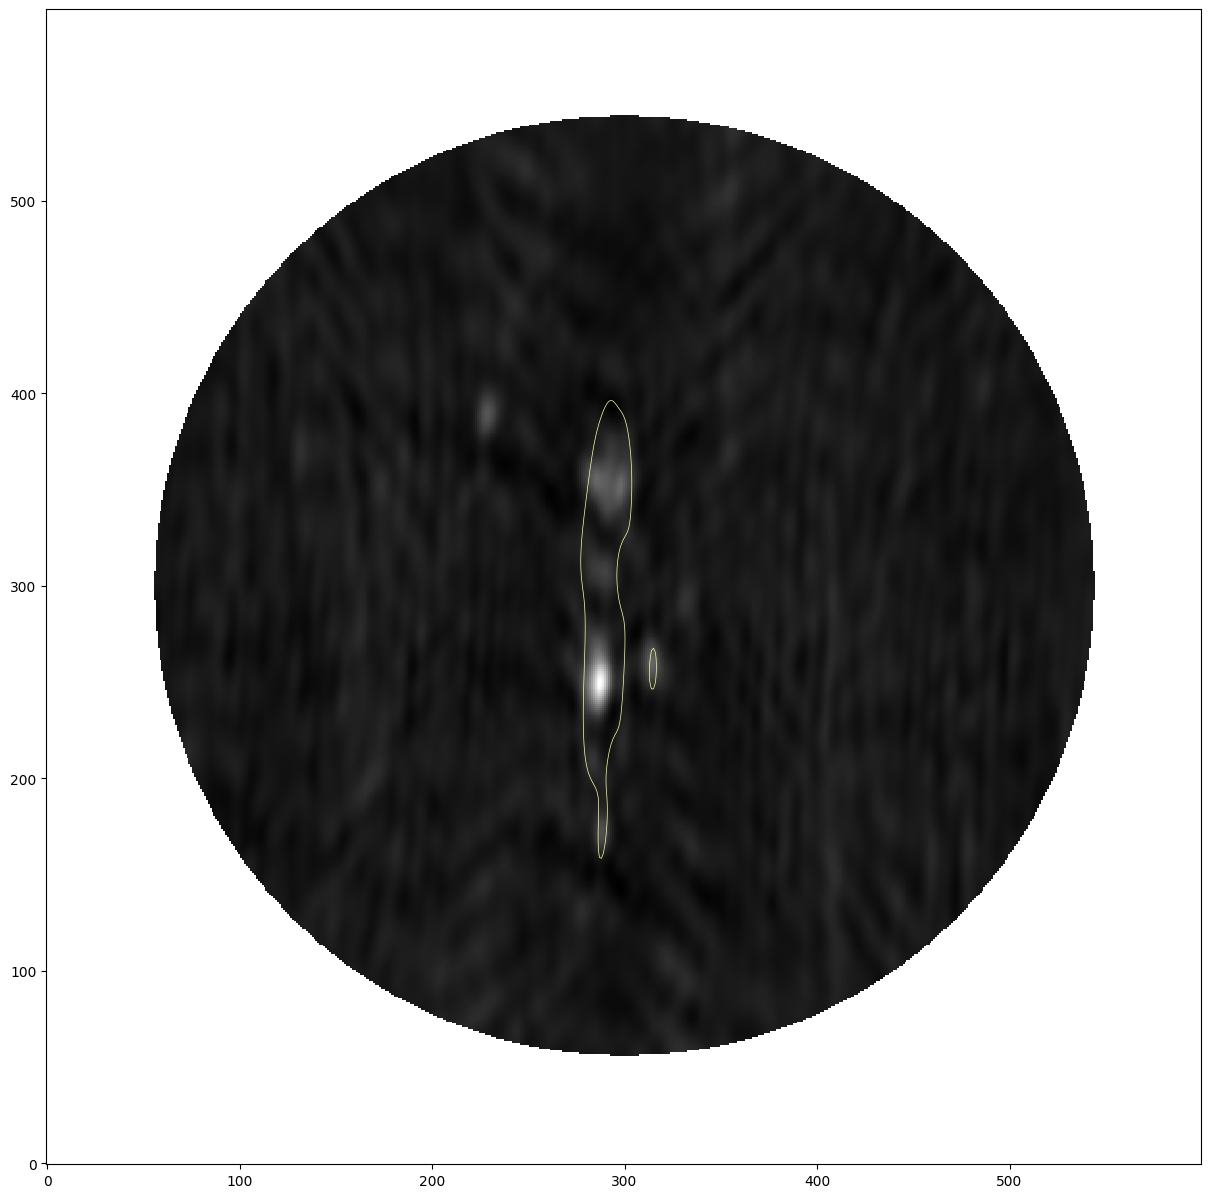

In [85]:
pl.figure(figsize=(15, 15))
m0 = rrlcube.spectral_slab(40*u.km/u.s, 76*u.km/u.s).moment0(axis=0)
pl.imshow(m0.value, cmap='gray')
pl.contour(cont_est.value, cmap='inferno_r', linewidths=0.5, levels=[0.6])

In [95]:
aperture.center.to_string('hmsdms')

'17h47m19.8s -28d22m17s'

In [88]:
aperture.to_pixel(mx.wcs)

<CirclePixelRegion(center=PixCoord(x=305.279301924723, y=345.999972788618), radius=49.2439196643841)>

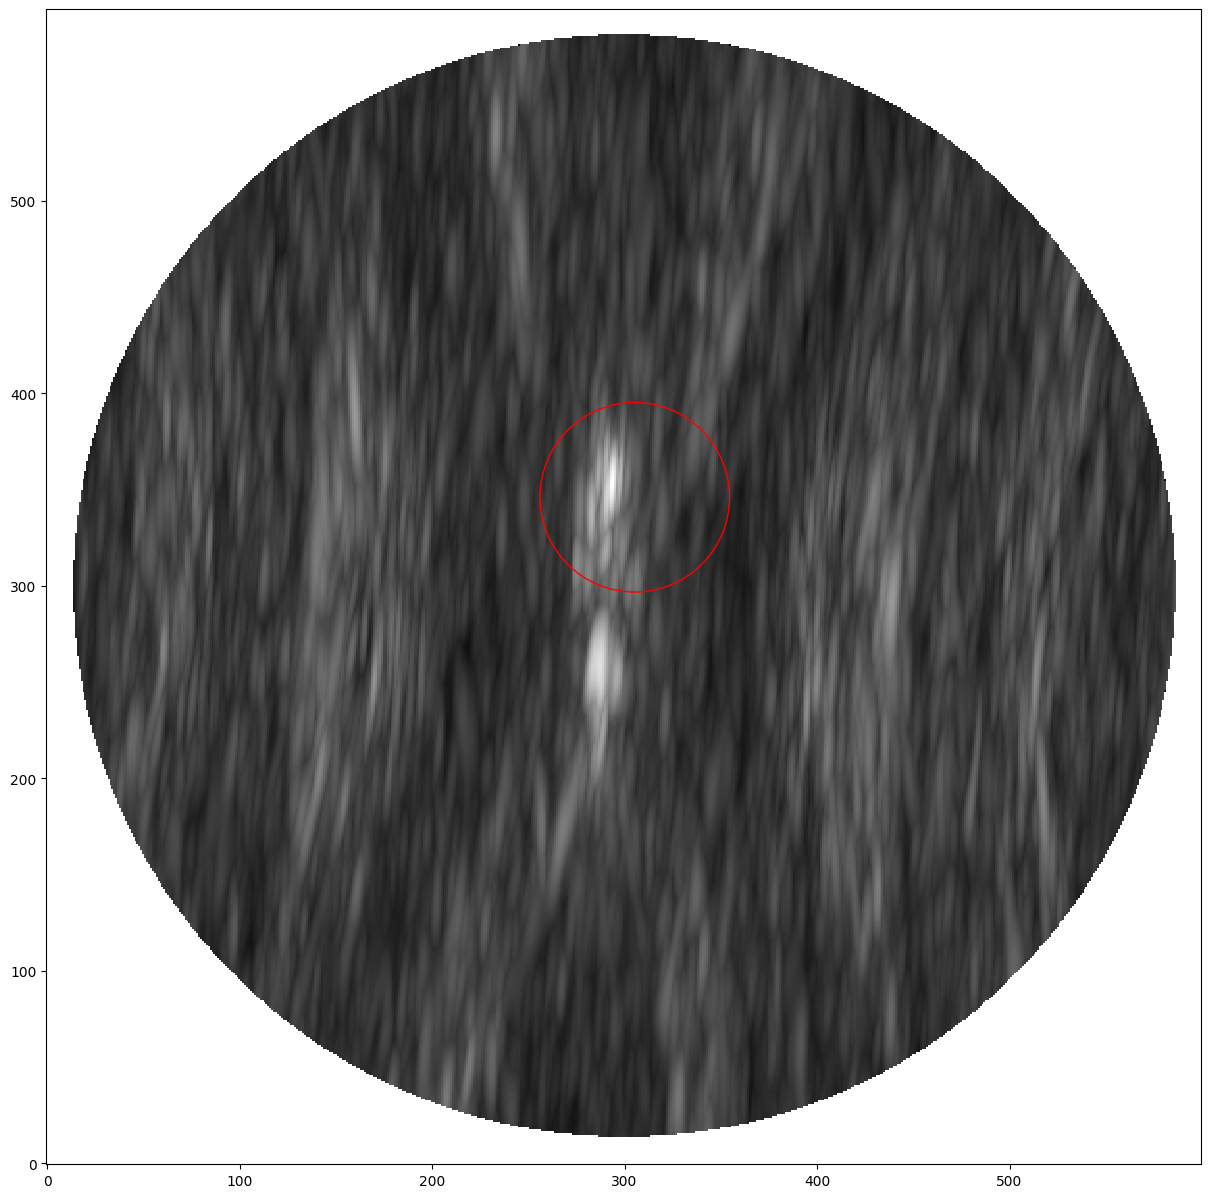

In [90]:
pl.figure(figsize=(15, 15))
mx = naclcube.spectral_slab(40*u.km/u.s, 76*u.km/u.s).max(axis=0)
pl.imshow(mx.value, cmap='gray')
aperture.to_pixel(mx.wcs).plot(edgecolor='r');
#pl.contour(cont_est.value, cmap='inferno_r', linewidths=0.5, levels=[0.6])